# Konvoluční sítě

Na přednášce jste se bavili o konvolučních sítích, které si dnes se vyzkoušíme i na cvičení. Navíc si ukážeme i *tensorboard*, což je nástroj pro provádění měření a vizualizace během machine learningových úkolů, a knihovnu *cleverhans* pro vytváření matoucích vzorů.

Konvoluční sítě jsou druhem sítí, které se používají při zpracování obrazu. Model vidí obrázek jako pole pixelů, a kdyby pro každý pixel měl být vlastní neuron, síť by měla obrovské množství parametrů a byla by nenatrénovatelná a velká. Proto se používají konvoluce, které spočívají v tom, že pomocí malých okének zvaných filtry čtou malé části obrázku a aplikují na ně operaci skalárního součinu hodnot s váhami sítě. Tyto filtry se postupně posouvají po celém obrázku a používají ty stejné váhy pro každou jeho část.

Například pro obrázek velikosti $n$ x $n$ s $k$ barevnými kanály by tedy měla další vrstva $n*n*k$ trénovatelných vah. Při použití konvoluce s velikostí okénka 3x3 tedy bude mít další vrstva najednou pouze 9 trénovatelných vah, což je výrazné zmenšení. Konvolučních vrstev se pro lepší výsledky může dávat více za sebe.

Konvoluce samotná nám ale nijak neredukuje dimenzi obrázku. K tomu se používají takzvané pooling vrstvy, které opět rozdělí obrázek na menší části a na každou aplikuje pooling a tím zmenší dimenzi obrázku. Často se používá max pooling, který z každé části vybírá maximální hodnotu, existuje ale i průměrová verze, kde se bere průměr z dané oblasti přes všechny hodnoty.

Kombinací konvoluce a pooling vrstev dostaneme zmenšenou reprezentaci obrázku a síť s rozumným počtem parametrů, které už se dají dobře trénovat.

In [1]:
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from tensorflow.keras.datasets import cifar10, mnist, fashion_mnist
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPool2D, Flatten, Dense, Activation
from tensorflow.keras.activations import linear, relu
from tensorflow.nn import softmax
from tensorflow.keras.utils import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input, decode_predictions

Implementovat konvoluční síť v tensorflow je skoro stejné jako implementace jiných architektur. Než se ale dostaneme k samotným modelům, podíváme se na tři často používané datasety. Začneme tím, že si napíšeme funkci na zobrazování obrázků z datasetu.

In [2]:
def show_dataset_examples(X, y, labels):
    plt.figure(figsize=(12,12))
    for i in range(25):
        idx = random.randint(0, X.shape[0]) 
        plt.subplot(5, 5, i+1)
        plt.imshow(X[idx])
        plt.title(labels[y[idx]])
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()
    plt.show()

První z nich je datest MNIST, který obsahuje 60,000 trénovacích a 10,000 testovacích černobílých obrázků číslic 0-9, každý normalizovaný do velikosti 28x28 pixelů. Každá třída obsahuje stejný počet obrázků.

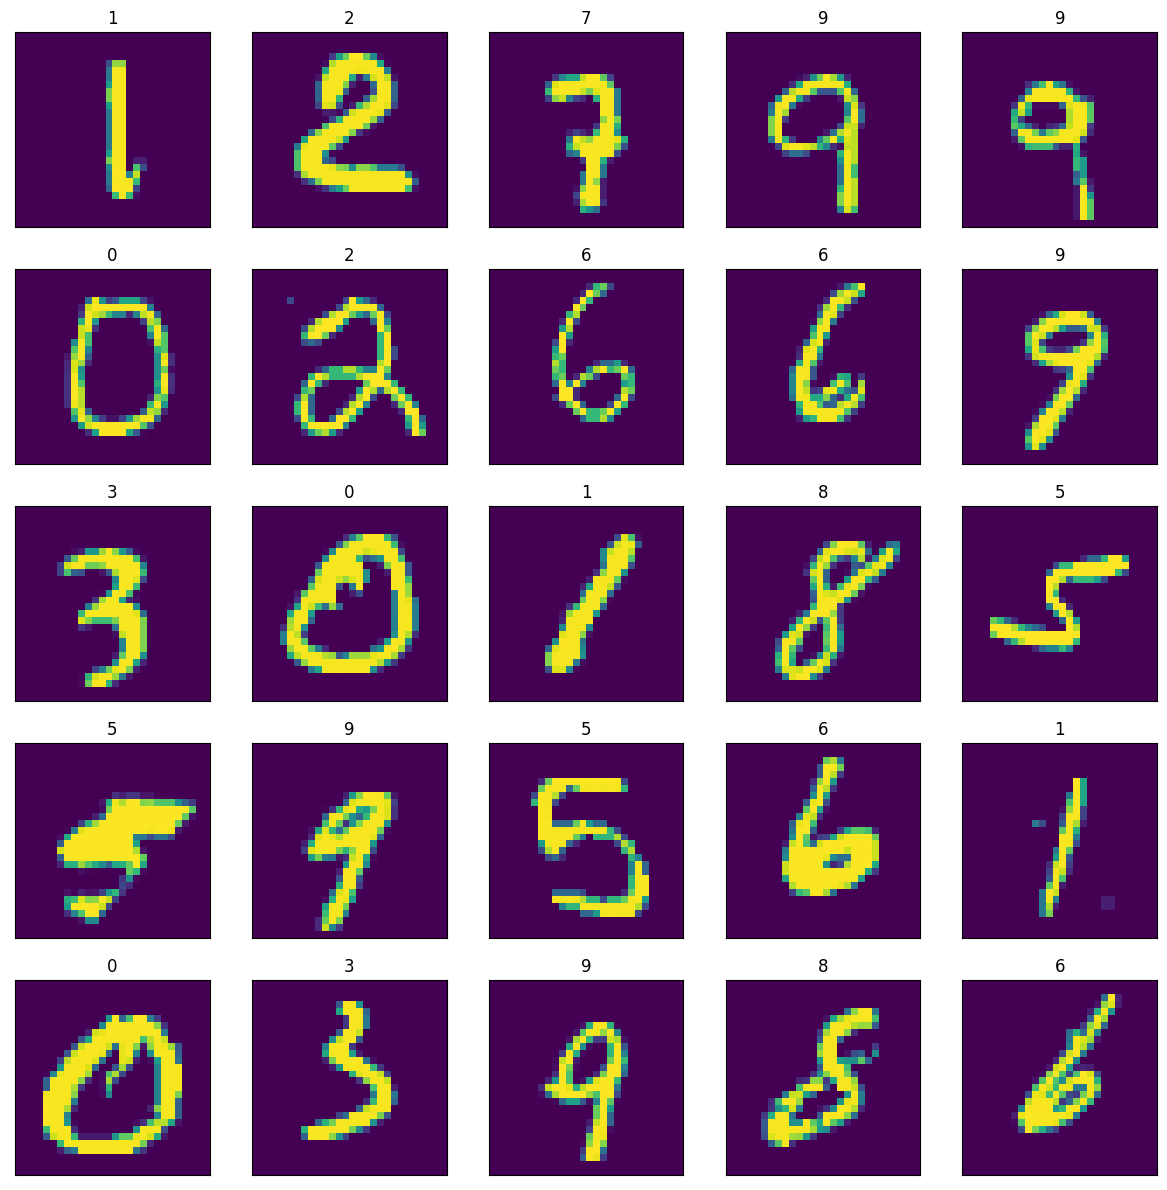

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
mnist_class_labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
show_dataset_examples(x_train, y_train, mnist_class_labels)

Druhý je Fashion-MNIST, který se skládá z 60,000 trénovacích a 10,000 testovacích černobílých obrázků oblečení. Každý z nich je o rozměrech 28x28 pixelů a patří do jedné z 10 tříd: T-shirt/top, Trouser, Pullover, Dress, Coat, Sandal, Shirt, Sneaker, Bag, Ankle boot.

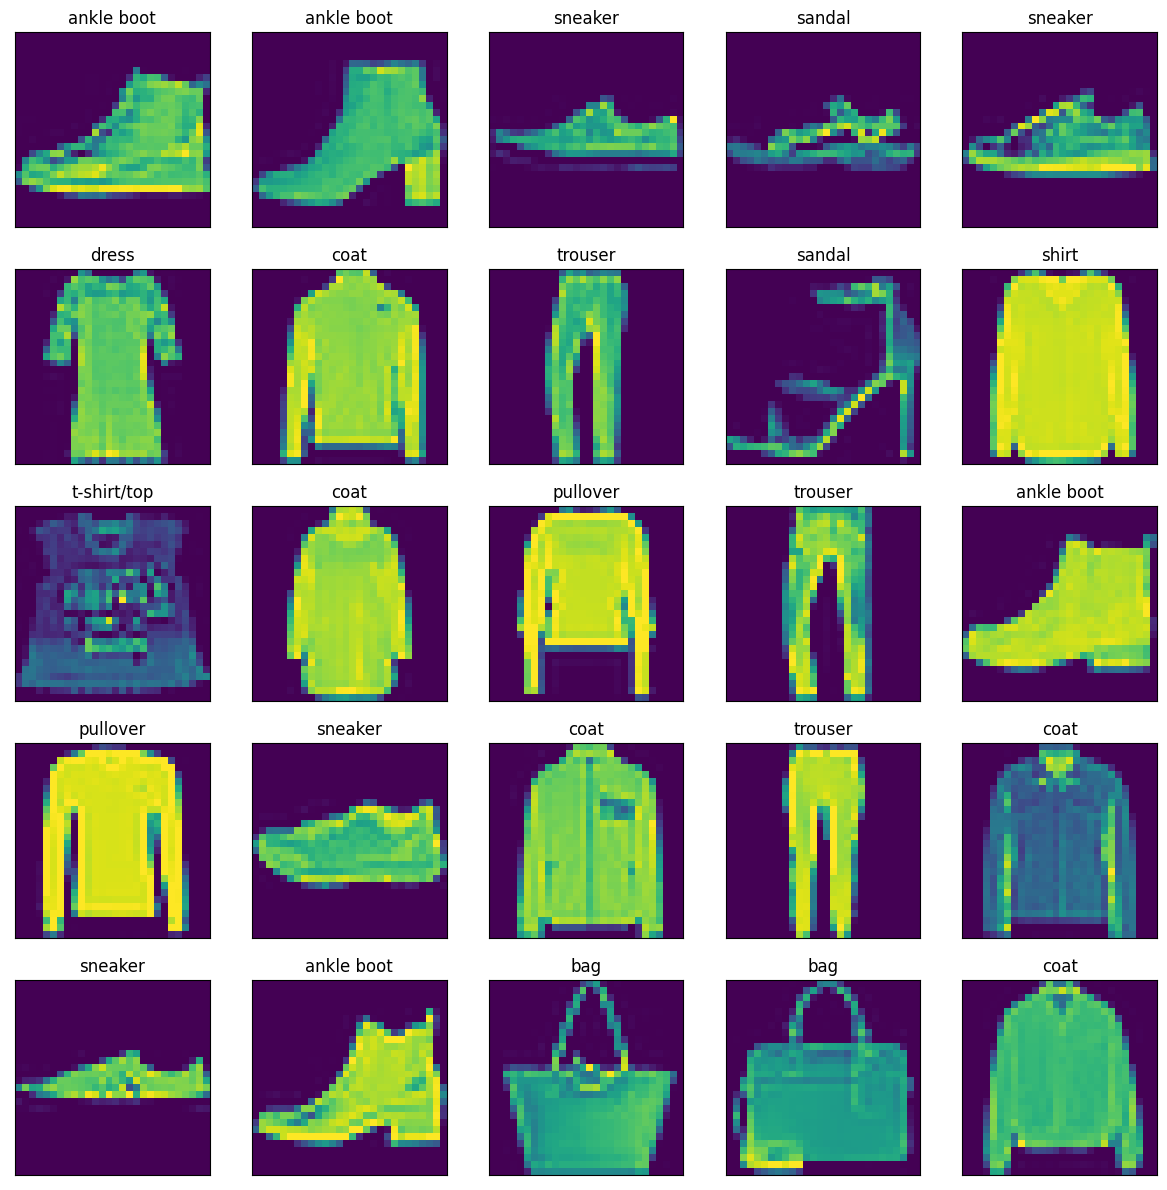

In [4]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
mnist_class_labels = ['t-shirt/top', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
show_dataset_examples(x_train, y_train, mnist_class_labels)

Poslední je CIFAR10, který obsahuje 50,000 trénovacích a 10,000 testovacích barevných obrázků z 10 různých tříd: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck. Obrázky jsou velikosti 32x32 pixelů a každá třída obsahuje přesně 5,000 obrázků. Existuje i verze CIFAR100, která obsahuje 100 výstupních labelů.

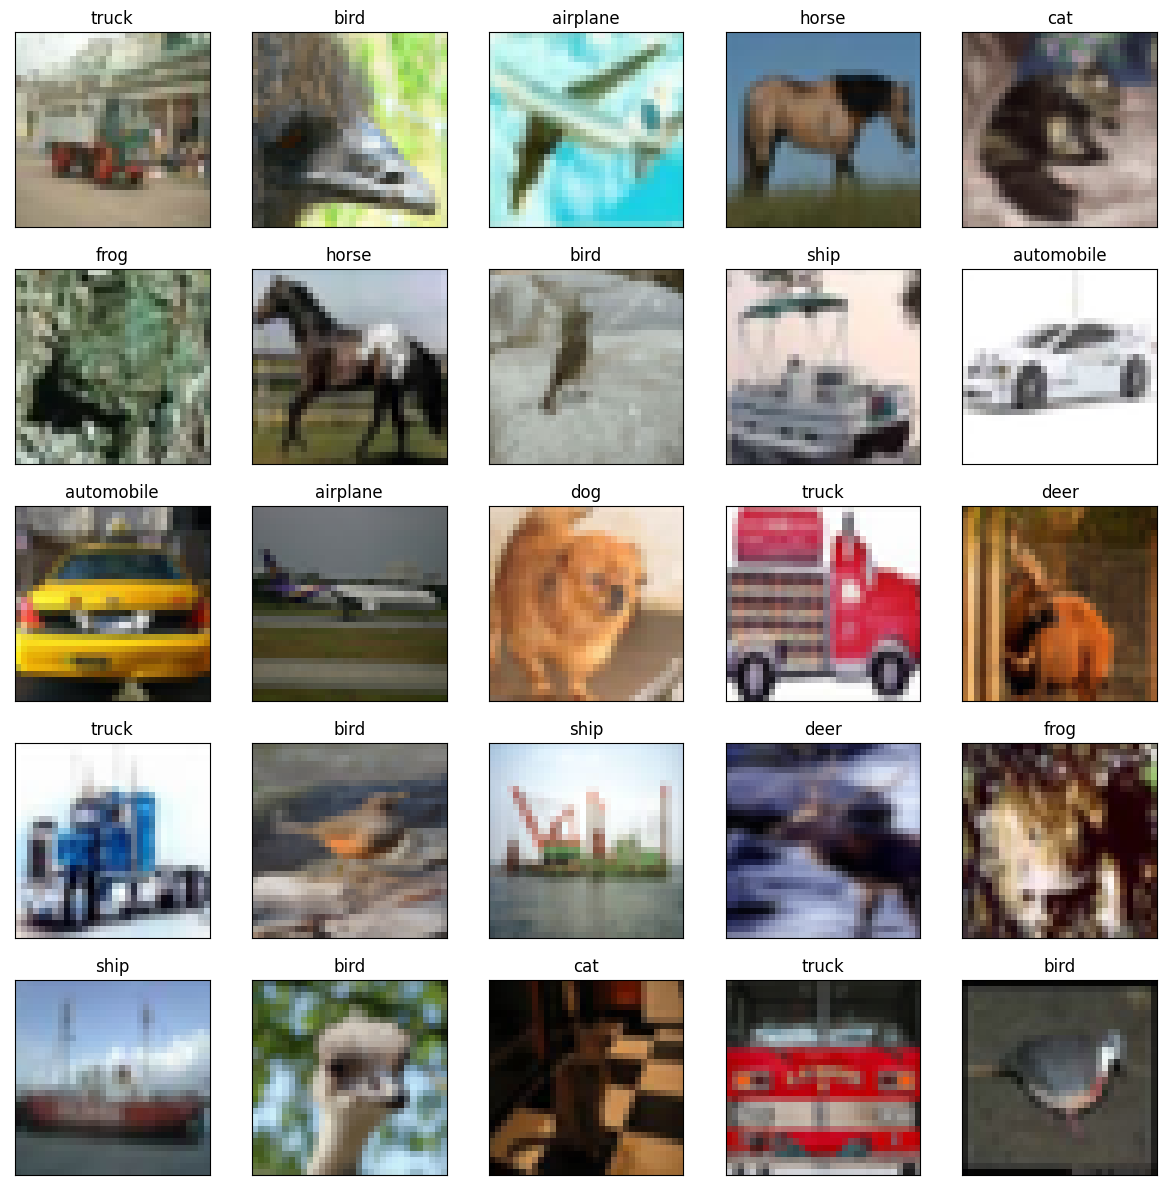

In [5]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

cifar_class_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
show_dataset_examples(x_train/255, list(map(lambda x: x[0], y_train)), cifar_class_labels)

Nyní se podíváme na implementaci samotné konvoluční sítě. Zkusíme si jednu vytvořit a natrénovat ji na klasifikaci číslic z MNISTu. Nejprve si načteme data.

In [6]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

nb_classes = 10
input_shape = (28, 28, 1)

x_train = x_train.reshape((-1,) + input_shape)/255

Nyní si definujeme samotný model sítě. Vidíme, že se skládá z několika vrstev.
- ```InputLayer``` je normální vrstva určená jako vstup do sítě s jedním parametrem rozměrů vstupu.
- ```Conv2D``` je 2D konvoluční vrstva s parametry počet filtrů (jader) v konvoluci a velikostí 2D konvolučního okénka.
- ```MaxPool2D``` je vrstva pro zmenšení dimenzionality vstupu, která má parametry početkroků a velikost toho, jak se má obrázek zmenšovat v obou dimenzích ((2,2) znamená, že se zmenší v obou rozměrech na polovinu). 
- ```Flatten``` je zploštující vrstva, tedy ze vstupu rozměrů (a,b) udělá výstup o rozměru a*b
- ```Dense``` je jen obyčejná vrstva se zadanou aktivací.
- ```Activation``` přidává k vrstvě aktivaci.

In [7]:
model = tf.keras.models.Sequential([])
model.add(InputLayer(input_shape = input_shape))
model.add(Conv2D(filters=32, kernel_size=(5, 5)))
model.add(MaxPool2D(strides=2, pool_size=(2, 2)))
model.add(Conv2D(filters=64, kernel_size=5, activation=relu))
model.add(MaxPool2D(strides=2, pool_size=(2, 2)))
model.add(Flatten(name='Flatten'))
model.add(Dense(units=30, activation=relu))
model.add(Dense(units=nb_classes, activation=linear, name='logits'))
model.add(Activation(activation=softmax))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Když nyní rozumíme jednotlivým vrstvám, můžeme se podívat na samotné trénovaní a vyhodnocení modelu. Model netrénujem na trénovacích datech a vyhodnotíme spočtením accuracy na testovacích datech.

In [8]:
model.fit(x_train, y_train, batch_size=128, epochs=2)

Epoch 1/2
469/469 [==============================] - 21s 43ms/step - loss: 0.2303 - accuracy: 0.9299
Epoch 2/2
469/469 [==============================] - 20s 42ms/step - loss: 0.0633 - accuracy: 0.9811


In [9]:
x_test = x_test.reshape((-1,) + input_shape)
model.evaluate(x_test/255, y_test)

313/313 [==============================] - 2s 4ms/step - loss: 0.0467 - accuracy: 0.9845


[0.046668801456689835, 0.984499990940094]

## Matoucí vzory

Na přednášce jste se bavili i o tom, že konvoluční sítě lze docela snadno zmást pomocí tzv. matoucích vzorů. Matoucí vzory můžeme vygenerovat pomocí knihovny cleverhans. Tato knihovna potřebuje tensor aktivací před poslední (softmax) vrstvou. Tu jsme si ale pojmenovali logits, není tedy problém si ji z našeho modelu snadno vzít a zašumět ji. To se dělá tak, že se spočítá derivace chyby podle vstupního obrázku, z toho se udělá signum, pronásobí se epsilonem a přičte se ke vstupu. Epsilon je pole hodnot, které obsahuje různé míry zašumění a můžeme tedy dobře sledovat, jak jeho hodnota zašumělost ovlivňuje.

Přidáme tedy matoucí vzory s různými mírami zašumnění před poslední vrstvu a pustíme evaluaci už předtrénovaného modelu. Můžeme sledovat, jak se nám poměrně rychle snižuje accuracy modelu i s malým zašumněním.

In [10]:
from cleverhans.tf2.attacks.fast_gradient_method import fast_gradient_method

logits = tf.keras.Model(model.inputs, model.get_layer('logits').output)

results = []
eps_vals = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]
for eps in eps_vals:
    # Replace clean example with adversarial example for adversarial training
    x_fgm = fast_gradient_method(model, x_test/255, eps, np.inf)
    r = model.evaluate(x_fgm, y_test)[1]
    results.append(r)

print(results)

313/313 [==============================] - 1s 4ms/step - loss: 16.3214 - accuracy: 0.0150
[0.984499990940094, 0.850600004196167, 0.46320000290870667, 0.14059999585151672, 0.04129999876022339, 0.02329999953508377, 0.01850000023841858, 0.015599999576807022, 0.014999999664723873]


Nyní si vykreslíme dataset CIFAR10 s přidáním matoucích vzorů. Můžeme si porovnat, jak se liší od původního.

Epsilon value: 0.0


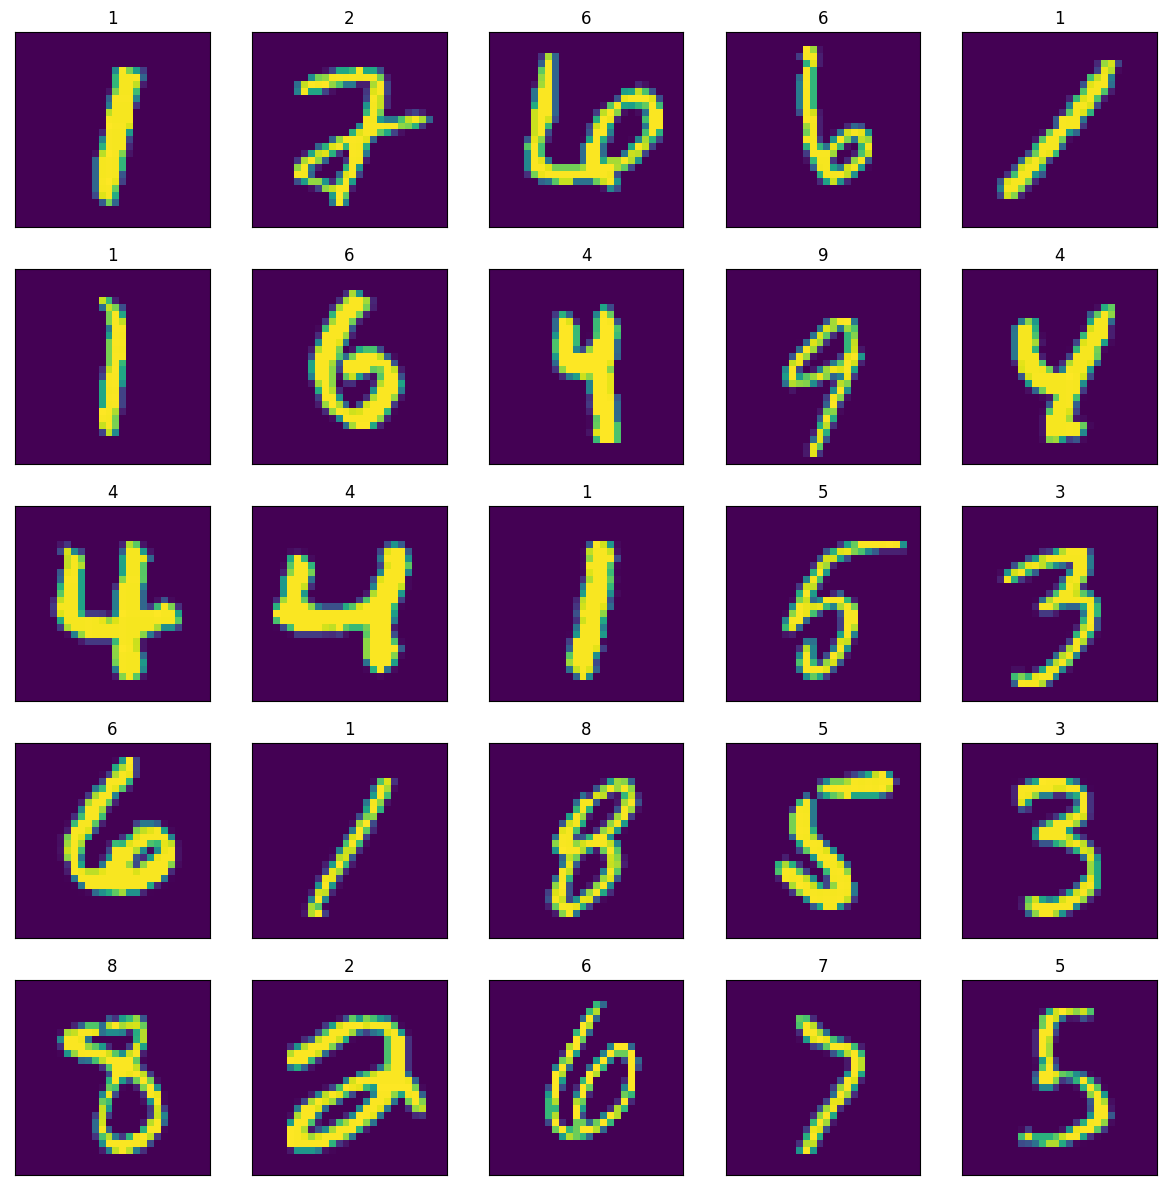

Epsilon value: 0.1


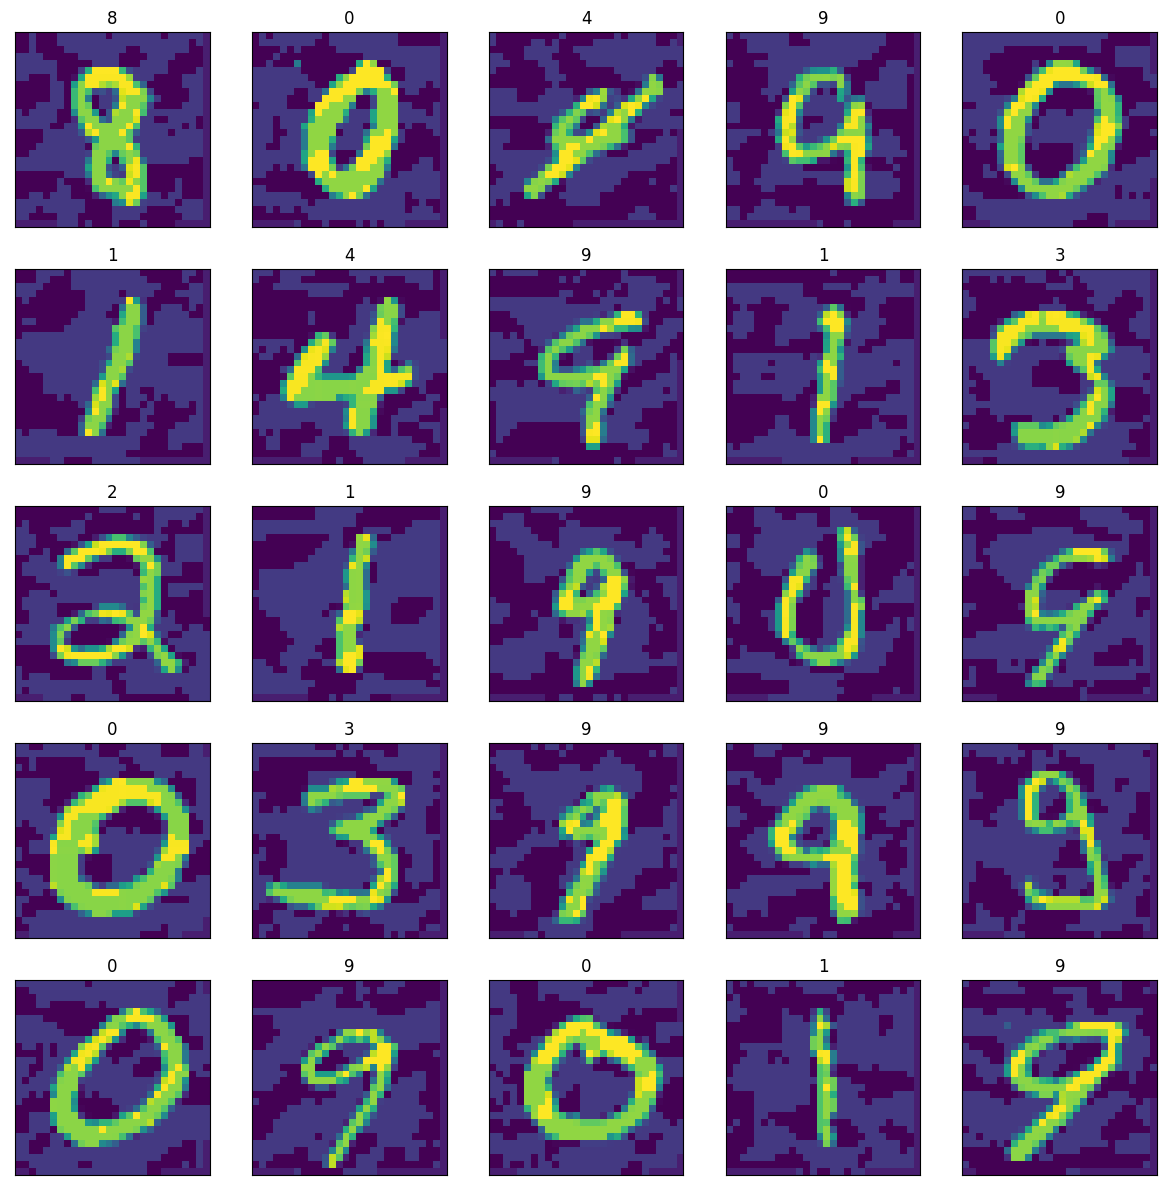

Epsilon value: 0.2


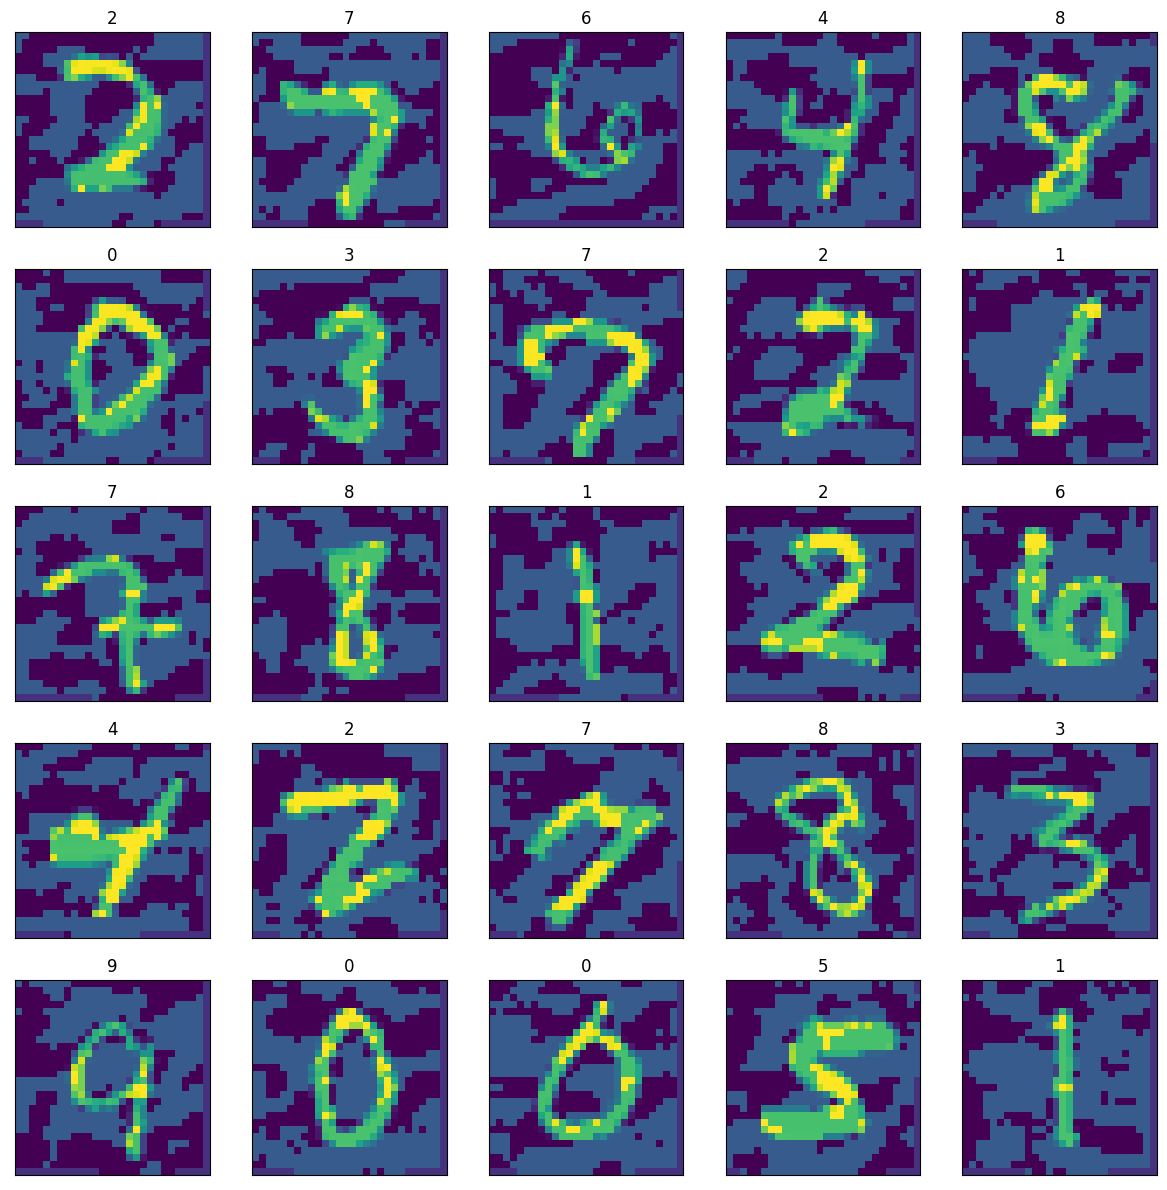

Epsilon value: 0.3


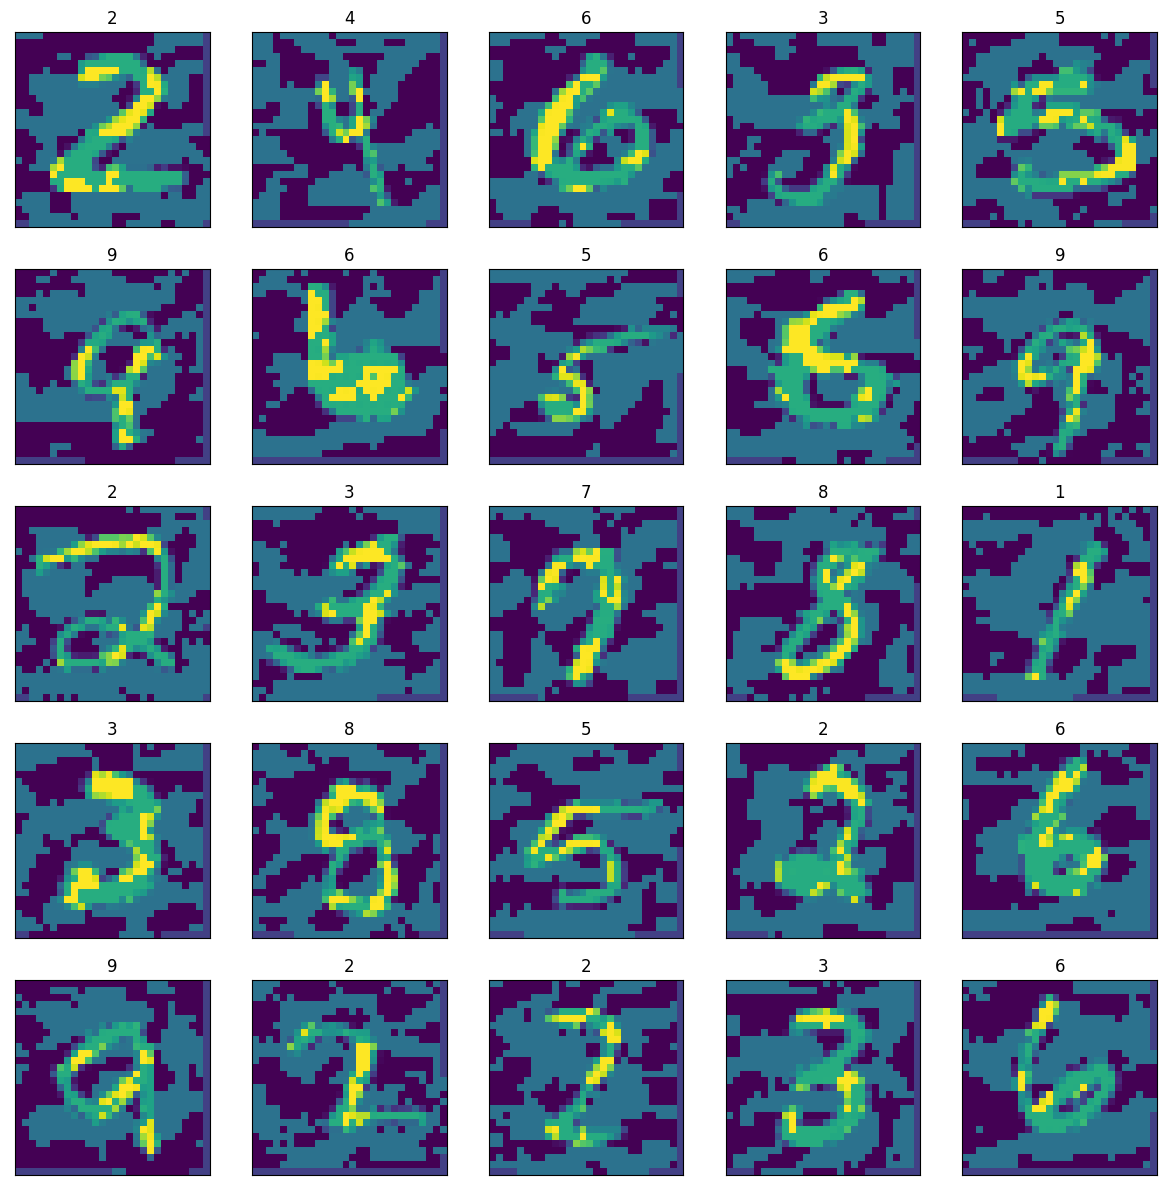

Epsilon value: 0.4


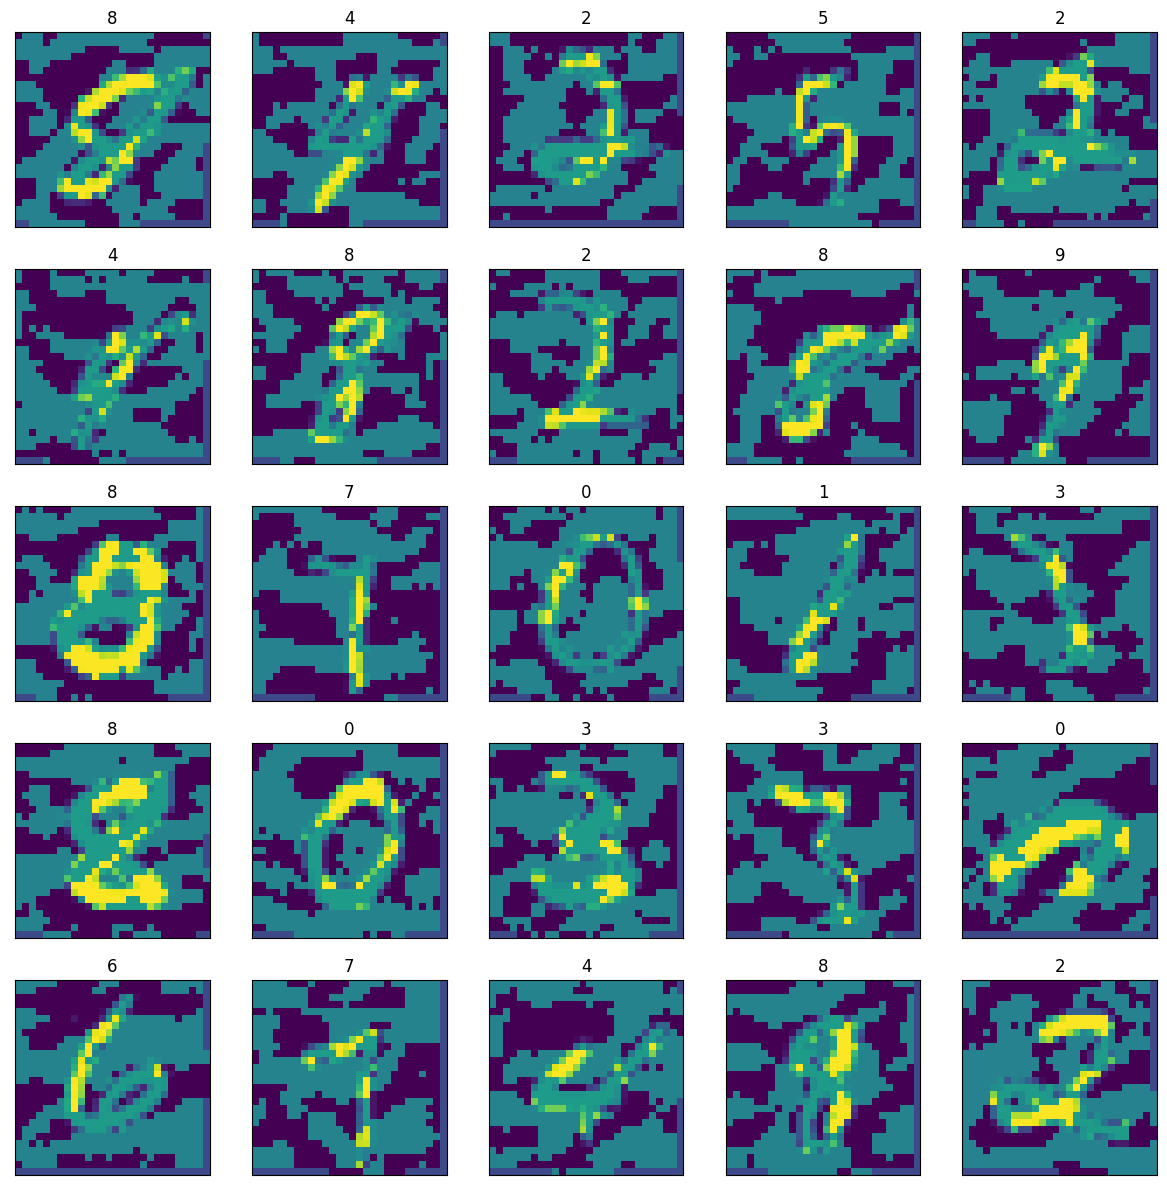

In [11]:
mnist_class_labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

eps_vals = [0.0, 0.1, 0.2, 0.3, 0.4]
for eps in eps_vals:
    x_fgm = fast_gradient_method(model, x_test/255, eps, np.inf)
    adv_x = tf.reshape(x_fgm, [-1, 28, 28])
    print(f'Epsilon value: {eps}')
    show_dataset_examples(x_fgm, y_test, mnist_class_labels)

## Úkol na cvičení

Zkuste si pustit evaluaci zašumnělých vzorů i pro CIFAR10 dataset a porovnat, jak se liší výsledky od výsledků pro dataset MNIST a CIFAR10. Také si můžete zkusit natrénovat síť už na zašumnělých vzorech a podívat se, jestli si s nimisíť dokáže lépe poradit. Na závěr si zkuste natrénovat konvoluční síť na Fashion-MNIST a najít nejčastější chyby, kterých se síť při klasifikaci dopouští.

## Image classification

[ImageNet](http://www.image-net.org/) je výzkumý projekt pro vyvíjení velké databáze anatovaných obrázků, tj. obrázků a jejich popis. Na nich se dají trénovat konvoluční sítě například pro image classification task. Bohužel natrénovat takovou síť na takto obrovských datech trvá řádově dny až týdny a to ještě na výkonných grafických kartách. Naštěstí knihovna keras obsahuje některé modely neuronových sítí pro klasifikaci obrázků s už předtrénovanými váhami, takže je nemusíme trénovat celé znovu, ale můžeme je používat a třeba si je jen dotrénovávat na konkrétních datech. Nejznámějšími takovými modely jsou [The Oxford VGG Models](https://www.robots.ox.ac.uk/~vgg/research/very_deep/). My se teď podíváme, jak vypadá jeden z nich, konkrétně VGG16, který je trénovaný na obrázcích z ImageNetu na predikci 1000 různých tříd.

In [12]:
from keras.applications.vgg16 import VGG16
model = VGG16()
print(model.summary())

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

Když víme, jaké model obsahuje vrstvy a jak vypadá, zkusíme si načíst nějaký obrázek a nechat model, aby predikoval, co na něm je.

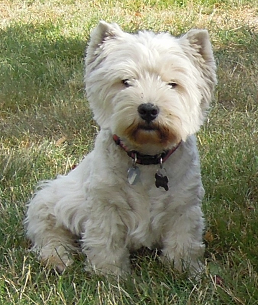

In [13]:
from PIL import Image
Image.open('dog.png')

Nejprve si načteme obrázek a převedeme pixely z něj do ```np.array``` a uděláme jeho reshape a preprocessing pro model. 

In [14]:
image = load_img('dog.png', target_size=(224, 224))
image = img_to_array(image)
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
image = preprocess_input(image)

Nyní necháme model predikovat pravděpodobnosti toho, co se na obrázku nachází přes všechny možné kategorie, převedeme pravděpodobnosti na labely a vybereme ten s největší pravděpodobností.

In [15]:
yhat = model.predict(image)
labels = decode_predictions(yhat)
label = labels[0][0]

print('%s (%.2f%%)' % (label[1], label[2]*100))
print(labels)

1/1 [==============================] - 0s 380ms/step
West_Highland_white_terrier (87.87%)
[[('n02098286', 'West_Highland_white_terrier', 0.87867284), ('n02085936', 'Maltese_dog', 0.038101435), ('n02094114', 'Norfolk_terrier', 0.020698663), ('n02095889', 'Sealyham_terrier', 0.018502548), ('n02097298', 'Scotch_terrier', 0.010451289)]]


Pokud bychom se chtěli podívat na pravděpodobnosti všech 1000 tříd, stačí nám k predikcím přidat parametr, že chceme prvních 1000 labelů. Raději si ale zobrazíme jen prvních 100, aby se nám výpis rozumně vešel na stránku.

In [16]:
labels = decode_predictions(yhat, top=100)
labels = labels[0][:]
labels = [y for (x,y,z) in labels]
print(labels)

['West_Highland_white_terrier', 'Maltese_dog', 'Norfolk_terrier', 'Sealyham_terrier', 'Scotch_terrier', 'miniature_schnauzer', 'wire-haired_fox_terrier', 'Lhasa', 'cairn', 'Tibetan_terrier', 'Norwich_terrier', 'Yorkshire_terrier', 'Dandie_Dinmont', 'silky_terrier', 'Lakeland_terrier', 'Shih-Tzu', 'soft-coated_wheaten_terrier', 'Japanese_spaniel', 'Australian_terrier', 'Irish_terrier', 'standard_schnauzer', 'toy_poodle', 'miniature_poodle', 'Old_English_sheepdog', 'Pekinese', 'affenpinscher', 'Kerry_blue_terrier', 'Brabancon_griffon', 'Border_terrier', 'tennis_ball', 'cocker_spaniel', 'Pomeranian', 'French_bulldog', 'giant_schnauzer', 'clumber', 'toy_terrier', 'bucket', 'kuvasz', 'Staffordshire_bullterrier', 'teddy', 'Samoyed', 'Bouvier_des_Flandres', 'papillon', 'soccer_ball', 'Boston_bull', 'komondor', 'Persian_cat', 'Chihuahua', 'briard', 'otterhound', 'Great_Pyrenees', 'Bedlington_terrier', 'English_setter', 'pug', 'chow', 'water_bottle', 'toilet_tissue', 'boxer', 'basenji', 'Angora

Zkusíme si načíst nějaký další obrázek a opět nechat síť predikovat, co se na něm nachází.

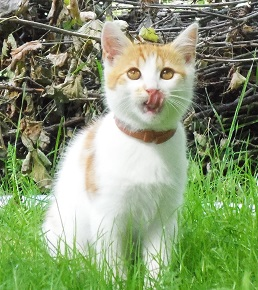

In [17]:
from PIL import Image
Image.open('cat.png')

In [18]:
image = load_img('cat.png', target_size=(224, 224))
image = img_to_array(image)
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
image = preprocess_input(image)

yhat = model.predict(image)
labels = decode_predictions(yhat)
label = labels[0][0]
print('%s (%.2f%%)' % (label[1], label[2]*100))
print(labels)

1/1 [==============================] - 0s 211ms/step
tiger_cat (58.94%)
[[('n02123159', 'tiger_cat', 0.5893759), ('n02123045', 'tabby', 0.10447724), ('n02124075', 'Egyptian_cat', 0.08740522), ('n02441942', 'weasel', 0.04024524), ('n02123597', 'Siamese_cat', 0.023020795)]]


## Domácí úkol

Za domácí úkol budete mít vytvořit si vlastní libovolný dataset na image classfication task, abyste si vyzkoušeli, že vyrábět data není úplně snadné. Dataset by měl mít aspoň 5 různých tříd ke klasifikaci a ke každé nějaké rozumné desítky obrázků.

Až budete mít data, tak si na nich zkuste image classification task. Jak už jsem zmínila výše, trénovat celou konvoluční síť od začátku by bylo početně náročné, proto budete mít za úkol si vybrat 3 z už predtrénovaných modelů například [odsud](https://www.pyimagesearch.com/2017/03/20/imagenet-vggnet-resnet-inception-xception-keras/) a přetrénovat je tak, aby uměly klasifikovat vámi vytvořená data.

Můžete si na vašich datech i zkusit natrénovat podobnou (klidně i stejnou) jednoduchou konvoluční síť, kterou jsme používali před na MNISTu výše a schválně se podívat, jak moc bude špatná oproti těm už předtrénovaným.

Své řešení mi pošlete emailem do stanoveného deadline. Pro sepsání popisu vašeho datasetu, zvolených modelů a rozboru výsledků použijte [tento template](https://github.com/kackamac/Prirodou-inspirovane-algoritmy/blob/master/08_konvoluce/DU2_konvolucni_site.pdf). Řešení by mělo obsahovat:
1. slovní popis vašich dat (jaké máte labely, kolik každý obsahuje obrázků, velikost obrázků, zdůvodnění volby datasetu)
2. váš kód
3. slovní popis výsledků a porovnání modelů (jaké jste použili, jak byl který úspěšný (accuraccy všech modelů na testovací množině, sepsaná třeba v nějaké pěkné tabulce) a který byl nejlepší)
4. vámi vytvořený předzpracovaný dataset (obrázky by měly být malé, takže by neměl být problém s posláním)

Pár tipů
- bylo by dobré mít u všech tříd stejný počet obrázků
- obrázky bude potřeba převést do nějakého jednotného rozumně malého rozměru (například 128 x 128 pixelů)
- když budete používat předtrénované sítě, tak ty vaše obrázky by měly být stejně velké jako ty, na kterých byla trénovaná ta  síť původně
- zároveň bude potřeba je rozdělit na dvě disjunktní množiny -- trénovací a testovací (trénovací na přetrénovaní modelů a testovací na jejich vyhodnocení)
- model se dá přetrénovat například tak, že si nahradíte poslední nebo několik posledních vrstev vlastními, které budete přetrénovávat podle vašich dat
- pokud se vám model nedaří přetrénovat, aby dosahoval nějakých rozumných výsledků, zkuste použít nějakou augmentaci dat a trénovat na větších datech
